In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models

# Loading the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Preprocessing the dataset

In [ ]:
# data normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# flatten the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# mark the categorical value for output
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


# SVD Parameter calculation for D = 20

1. loading the baseline model which was trained during previous problem.

2. Set Singlular decomposition value to 20 and calculate s, v, u

$${U}^{(l)} ← U^{(l)}_{:,1:20}$$

$${V}^{(l)} ← S^{(l)}_{1:20,1:20} transpose(V^{(l)}_{:,1:20})$$


In [ ]:
baseline_model = tf.keras.models.load_model('/content/baseline_model (2).h5')

D = 20
dense_layers = [layer for layer in baseline_model.layers if isinstance(layer, tf.keras.layers.Dense)]

svd_params = []
for i, layer in enumerate(dense_layers[:-1]):
    W, b = layer.get_weights()
    s, u, v = tf.linalg.svd(W)
    U_d = u[:, :D]
    S_d = tf.linalg.diag(s[:D])
    V_d = v[:, :D]
    U_init = U_d.numpy()
    V_init = tf.matmul(S_d, tf.transpose(V_d)).numpy()
    svd_params.append((U_init, V_init, b))


In [ ]:
Dense(D, use_bias=False)
Dense(1024)

<Dense name=dense_1, built=False>

# New model with Factorized weight

$${W}^{(l)} = {U}^{l} {V}^{{l}^T}$$


In [ ]:
# new model
input_dim = 784
output_dim =10

x = layers.Input(shape=(input_dim,))
out = x
for i, (U_init, V_init, b) in enumerate(svd_params):
    D = U_init.shape[1]
    out_dim = V_init.shape[1]

    U_layer = layers.Dense(D, use_bias=False, name=f"U_{i}")
    V_layer = layers.Dense(out_dim, use_bias=True, name=f"V_{i}")

    out = U_layer(out)
    out = V_layer(out)
    out = layers.ReLU()(out)

out = layers.Dense(output_dim, activation='softmax')(out)

model = models.Model(inputs=x, outputs=out)


model(x)

for i, (U_init, V_init, b) in enumerate(svd_params):
    model.get_layer(f"U_{i}").set_weights([U_init])
    model.get_layer(f"V_{i}").set_weights([V_init, b])



In [ ]:
factorized_model = model
factorized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                         loss='categorical_crossentropy',metrics=['accuracy'])

history = factorized_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    verbose=2
)


Epoch 1/50
422/422 - 10s - 24ms/step - accuracy: 0.8868 - loss: 0.3679 - val_accuracy: 0.9670 - val_loss: 0.1125
Epoch 2/50
422/422 - 6s - 13ms/step - accuracy: 0.9649 - loss: 0.1137 - val_accuracy: 0.9720 - val_loss: 0.0905
Epoch 3/50
422/422 - 7s - 16ms/step - accuracy: 0.9728 - loss: 0.0877 - val_accuracy: 0.9760 - val_loss: 0.0810
Epoch 4/50
422/422 - 6s - 14ms/step - accuracy: 0.9774 - loss: 0.0739 - val_accuracy: 0.9758 - val_loss: 0.0794
Epoch 5/50
422/422 - 9s - 20ms/step - accuracy: 0.9803 - loss: 0.0645 - val_accuracy: 0.9750 - val_loss: 0.0829
Epoch 6/50
422/422 - 9s - 20ms/step - accuracy: 0.9824 - loss: 0.0562 - val_accuracy: 0.9757 - val_loss: 0.0762
Epoch 7/50
422/422 - 6s - 13ms/step - accuracy: 0.9846 - loss: 0.0506 - val_accuracy: 0.9768 - val_loss: 0.0783
Epoch 8/50
422/422 - 13s - 31ms/step - accuracy: 0.9855 - loss: 0.0450 - val_accuracy: 0.9772 - val_loss: 0.0761
Epoch 9/50
422/422 - 9s - 21ms/step - accuracy: 0.9871 - loss: 0.0396 - val_accuracy: 0.9788 - val_los

In [ ]:
test_loss, test_acc = factorized_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy after fine-tuning {test_acc * 100:.2f}%")


Test Accuracy after fine-tuning 97.98%


In [ ]:
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(x_test, y_test, verbose=0)
print(f"Baseline Model Test Accuracy: {baseline_test_acc * 100:.2f}%")

Baseline Model Test Accuracy: 97.72%


In [ ]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,032,972 (19.20 MB)

 Trainable params: 5,022,730 (19.16 MB)

 Non-trainable params: 10,240 (40.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
factorized_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ U_0 (Dense)                     │ (None, 20)             │        15,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V_0 (Dense)                     │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ U_1 (Dense)                     │ (None, 20)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V_1 (Dense)                     │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ U_2 (Dense)                     │ (None, 20)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V_2 (Dense)                     │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ U_3 (Dense)                     │ (None, 20)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V_3 (Dense)                     │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ U_4 (Dense)                     │ (None, 20)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ V_4 (Dense)                     │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,112 (2.46 MB)

 Trainable params: 215,370 (841.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 430,742 (1.64 MB)

# Interference: The Parameter size of the baseline model is higher. By network compression, it have been reduced in Factorized model.

Text(0.5, 0, 'Epoch')

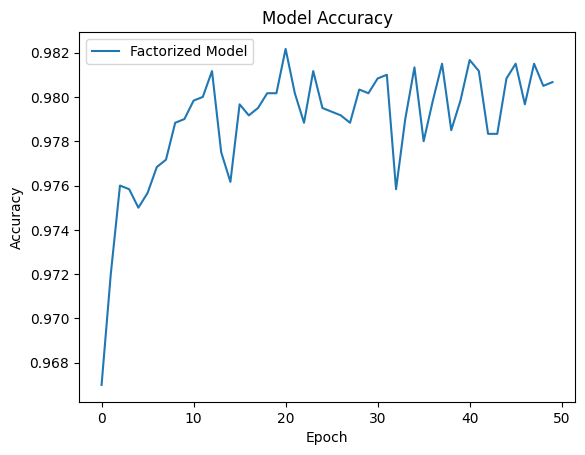

In [ ]:
import matplotlib.pyplot as plot
plot.plot(history.history['val_accuracy'])
plot.legend(['Factorized Model'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/DLS_HW_3_2.ipynb"
files.download("/content/drive/MyDrive/Colab Notebooks/DLS_HW_3_2.html")

Mounted at /content/drive
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/DLS_HW_3_2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 376170 bytes to /content/drive/MyDrive/Colab Notebooks/DLS_HW_3_2.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>